In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using MultivariateStats
using KernelFunctions, MAT, LoopVectorization

In [3]:
include("MultiSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Load data

In [4]:
my_file_data = open("3PhData/DataTrn.txt");
data = read(my_file_data,String);
data = parse.(Float64, split(chop(data; head=1, tail=1)));
data = [data[i:i+11] for i=1:12:length(data)];
;

In [5]:
# N = length(data)
N = 200
data = data[1:N];

In [6]:
my_file_label = open("3PhData/DataTrnLbls.txt");
label_data = read(my_file_label,String)
label_data = parse.(Float64, split(chop(label_data; head=1, tail=1)));
label_data = [label_data[i:i+2] for i=1:3:length(label_data)];

label_data = label_data[1:N];
;

In [7]:
label_text = Vector{Any}(undef,length(label_data))
for i=1:length(label_data)
    if label_data[i] == [1.0, 0.0, 0.0]
        label_text[i] = "Homogeneous"
    elseif label_data[i] == [0.0, 1.0, 0.0]
        label_text[i] = "Annular"
    else label_text[i] = "Stratified"
    end
end

pos_lb_homogeneous = findall((x) -> x=="Homogeneous",label_text)
pos_lb_annular = findall((x) -> x=="Annular",label_text)
pos_lb_stratified = findall((x) -> x=="Stratified",label_text)
;

In [8]:
D_out = length(data[1])
D_in = 2
;

In [9]:
# perform PCA
matrix_data = hcat(data...) ;
M = fit(PCA, matrix_data; maxoutdim=2)
mX = predict(M, matrix_data)
;

In [10]:
mean_X = [mX[:,i] for i=1:N];

## GPLVM model

In [11]:
# @model function GPLVM(y,Xm, d_in, d_out, Kuu_big)
    
#     v ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu_big,1)), Kuu_big)
    
#     for i=1:length(y)
#         x[i] ~ MvNormalMeanCovariance(Xm[i], 100diageye(d_in))
#         y[i] ~ MultiSGP(x[i],v,1e2diageye(d_out)) where { dependencies = RequireMarginalFunctionalDependencies(in = MvNormalMeanCovariance(mean_X[i], diageye(d_in)),)}
#     end
# end
# ;

@model function GPLVM(y,Xm, d_in, d_out, Kuu_big,θ)
    
    v ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu_big,1)), Kuu_big)
    
    for i=1:length(y)
        x[i] ~ MvNormalMeanCovariance(Xm[i], 100diageye(d_in))
        y[i] ~ MultiSGP(x[i],v,1e2diageye(d_out),θ) where { dependencies = RequireMarginalFunctionalDependencies(in = MvNormalMeanCovariance(mean_X[i], diageye(d_in)),)}
    end
end
;

## Configure GP

In [12]:
Random.seed!(86)
M = 30
pos_Xu = randperm(N)[1:M]
Xu = mean_X[pos_Xu]

kernel_gp(θ)   =  θ[1] * with_lengthscale(SEKernel(),[θ[2],θ[3]]) 
meanfunc = (x) -> 0.0

C = diageye(D_out)  #coregionalization matrix 
# Kuu_big = kron(C,kernelmatrix(kernel_gp(θ_optimal), Xu))
# dim_v = size(C,1) * length(Xu)
;

In [13]:
@meta function GPLVM_meta(method,Xu,C,kernel,cache)
    MultiSGP() -> MultiSGPMeta(method,Xu,C,kernel,cache)
end

gp_constraint = @constraints begin
    q(x,v) = q(x)q(v)
end
;

In [14]:
function my_free_energy(θ)
    Kuu_big_local = kron(C,kernelmatrix(kernel_gp(θ), Xu))

    init = @initialization begin
        q(v) = MvNormalWeightedMeanPrecision(zeros(size(Kuu_big_local,1)), Kuu_big_local)
    end
    
    infer_result_gp = infer(
        model = GPLVM(d_in = D_in, d_out = D_out, Kuu_big = Kuu_big_local,θ = θ),
        iterations = 4,
        data = (y = data, Xm = mean_X,),
        initialization = init,
        constraints = gp_constraint,
        meta = GPLVM_meta(srcubature(),Xu, C,kernel_gp,GPCache()),
        free_energy = true,
    ) 
    return infer_result_gp.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [0.1,0.1,0.1]
    upper = [5,1,1]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [126]:
θ_init = [1, 0.3 , 0.5]
θ_optimal= learn_params(θ_init,5)

3-element Vector{Float64}:
 0.35423239597622325
 0.6072869036732204
 0.7966347863638669

In [16]:
Kuu_big = kron(C,kernelmatrix(kernel_gp(θ_optimal), Xu))
gp_initialization = @initialization begin
    q(v) = MvNormalWeightedMeanPrecision(zeros(size(Kuu_big,1)), Kuu_big)
end
niter =10

infer_result_gp = infer(
    model = GPLVM(d_in = D_in, d_out = D_out, Kuu_big = Kuu_big, θ = θ_optimal,),
    iterations = niter,
    data = (y = data, Xm = mean_X,),
    initialization = gp_initialization,
    constraints = gp_constraint,
    meta = GPLVM_meta(srcubature(),Xu, C,kernel_gp,GPCache()),
    returnvars = (x = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:02:02


Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[71533.6, 2045.06, 1238.02, 1061.52, 973.884, 922.928, 888.064, 861.928, 840.468, 822.099]


In [17]:
qx = infer_result_gp.posteriors[:x];
;

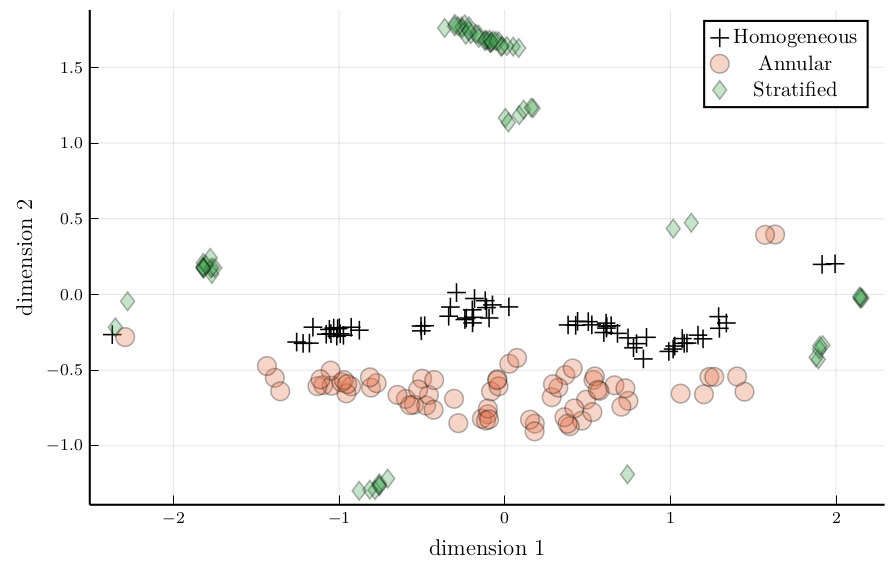

In [26]:
# contourf(x, y, p,fill=true, levels=20, color=:pigeon)
scatter(getindex.(mean.(qx),1)[pos_lb_homogeneous],getindex.(mean.(qx),2)[pos_lb_homogeneous],
        label = "Homogeneous",
        markersize=6.,
        legend=:topright,
        marker = :cross,
        fontfamily="monospace",legendfontsize=10)

scatter!(getindex.(mean.(qx),1)[pos_lb_annular],getindex.(mean.(qx),2)[pos_lb_annular],
        label = "Annular",
        markersize=6.,
        alpha=0.3)

scatter!(getindex.(mean.(qx),1)[pos_lb_stratified],getindex.(mean.(qx),2)[pos_lb_stratified],
        label = "Stratified",
        markersize=6.,
        marker = :diamond,
        alpha=0.3)
xlabel!("dimension 1")
ylabel!("dimension 2")

In [27]:
savefig("texfiles/GPLVM_SGPresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_SGPresult.svg"

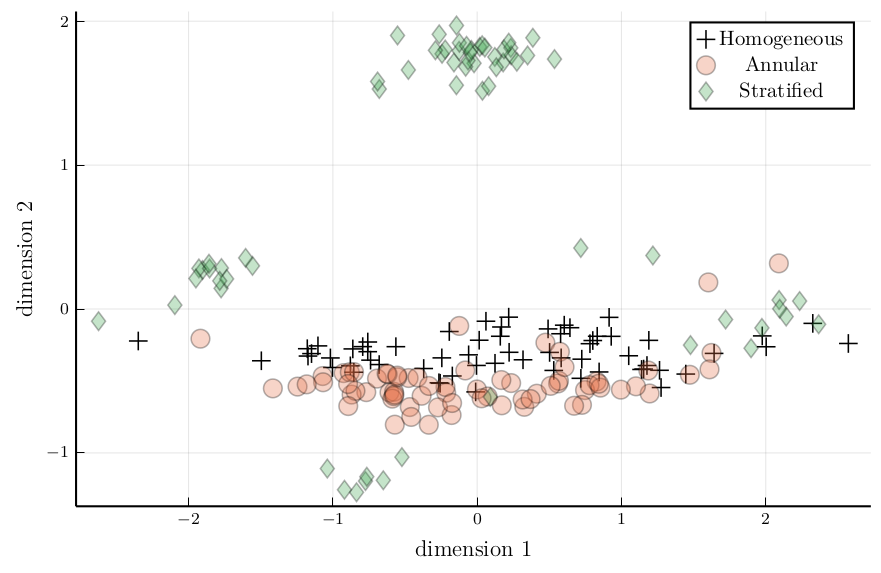

In [28]:
scatter(mX[1,pos_lb_homogeneous],mX[2,pos_lb_homogeneous],label = "Homogeneous",
         markersize=6,
         legend=:topright,
         marker = :cross,
         fontfamily="monospace",legendfontsize=10)

scatter!(mX[1,pos_lb_annular],mX[2,pos_lb_annular],label = "Annular",
        markersize=6,
        alpha=0.3)
scatter!(mX[1,pos_lb_stratified],mX[2,pos_lb_stratified],label = "Stratified",
        markersize=6,
        marker=:diamond,
        alpha=0.3)
xlabel!("dimension 1")
ylabel!("dimension 2")

In [29]:
savefig("texfiles/GPLVM_PCAresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_PCAresult.svg"

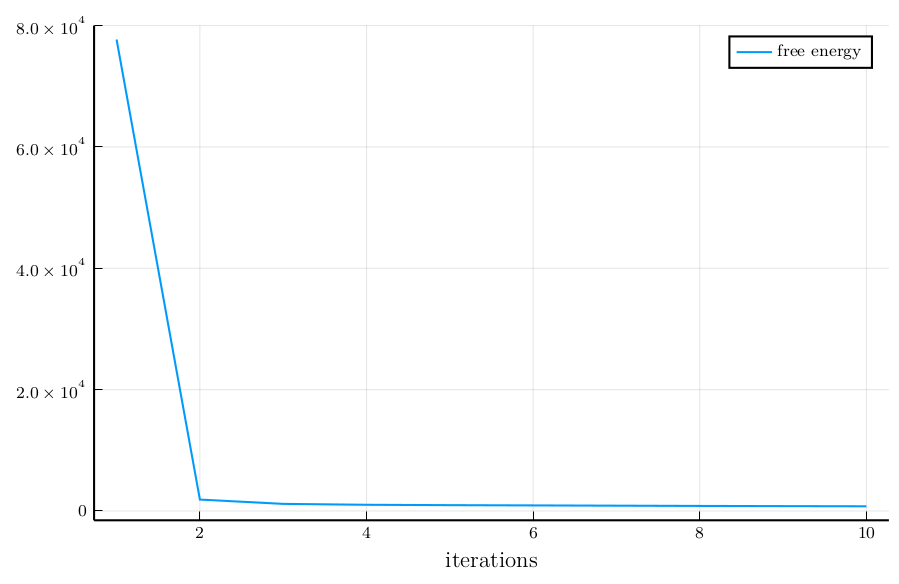

In [55]:
plot(infer_result_gp.free_energy, label="free energy", legend=:topright)
xlabel!("iterations")

In [56]:
savefig("texfiles/GPLVM_FE.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_FE.svg"

In [ ]:
# x = -2.5:0.02:2.5
# y = -2.5:0.02:2.5
# X = repeat(reshape(x, 1, :), length(y), 1)
# Y = repeat(y, 1, length(x))

# function myfunc(d, X, Y)
#     Z = map((x,y) -> pdf(d,[x,y]), X, Y)
#     replace!(x -> x < 1e-6 ? 0. : x, Z)
#     return Z
# end

# p = zeros(length(x),length(x))
# for i=1:length(qx) 
#     p += myfunc(qx[i],X,Y)
# end
# contourf(x, y, p,fill=true, levels=20, color=:pigeon)